In [ ]:
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

import sys
sys.path.insert(0, '/data/shiyu/projects/MT/MT_ICML_OOP')
from models.manifold_traversal import ManifoldTraversal

from GW.MT_networks_wrapper import MTNetworksWrapper

np.random.seed(42)

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]
})

# load data

In [2]:
sigma = 0.01
d = 2 

"""Load training and test data."""
print("Loading training data...")
train_file = os.path.join('/data/shiyu/projects/MT/MT_ICML_OOP/data/GW_data', 'datawaves_100000_spinsFalse_nonuniform.npy')
train_waves = np.load(train_file)

print("Loading test data...")
test_file = os.path.join('/data/shiyu/projects/MT/MT_ICML_OOP/data/GW_data', 'datawaves_20000_spinsFalse_nonuniform.npy')
test_waves = np.load(test_file)


X_natural_train = train_waves.T
X_natural_test = test_waves.T

N_train = X_natural_train.shape[1]
N_test = X_natural_test.shape[1]
D = X_natural_train.shape[0]

X_train = X_natural_train + sigma * np.random.randn(*X_natural_train.shape)
X_test = X_natural_test + sigma * np.random.randn(*X_natural_test.shape)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Ambient dimension (D): {D}")
print(f"Intrinsic dimension (d): {d}")
print(f"Noise level (sigma): {sigma}")

Loading training data...
Loading test data...
Training data shape: (2048, 100000)
Test data shape: (2048, 20000)
Ambient dimension (D): 2048
Intrinsic dimension (d): 2
Noise level (sigma): 0.01


# training

In [ ]:
networks_wrapper_GW = MTNetworksWrapper(X_train=X_train, X_natural_train=X_natural_train, X_test=X_test, X_natural_test=X_natural_test,
                          sigma=sigma, d=d)

In [5]:
save_path = '/data/shiyu/projects/MT/MT_ICML_OOP/GW/trained_models_info/MT_networks_GW/MT_networks_info.pkl'
networks_wrapper_GW.train_networks(batch_size=4000, save_path=save_path)

Training 12 networks with different hyperparameters...

Training NETWORK_1
Config: {'R_is_const': False, 'R_denoising': 0.6495290601659021, 'R_1st_order_nbhd': 0.6996227554904143, 'd_parallel': 0.06324555320336758, 'prod_coeff': 1.2, 'exp_coeff': 0.5}
------------------------------------------------------------
Training manifold traversal on 100000 samples...
4000 samples processed (batch time: 3.33s)
8000 samples processed (batch time: 4.71s)
12000 samples processed (batch time: 5.52s)
16000 samples processed (batch time: 6.07s)
20000 samples processed (batch time: 6.86s)
24000 samples processed (batch time: 7.04s)
28000 samples processed (batch time: 7.05s)
32000 samples processed (batch time: 7.34s)
36000 samples processed (batch time: 7.92s)
40000 samples processed (batch time: 8.37s)
44000 samples processed (batch time: 8.81s)
48000 samples processed (batch time: 9.51s)
52000 samples processed (batch time: 9.30s)
56000 samples processed (batch time: 9.78s)
60000 samples processed 

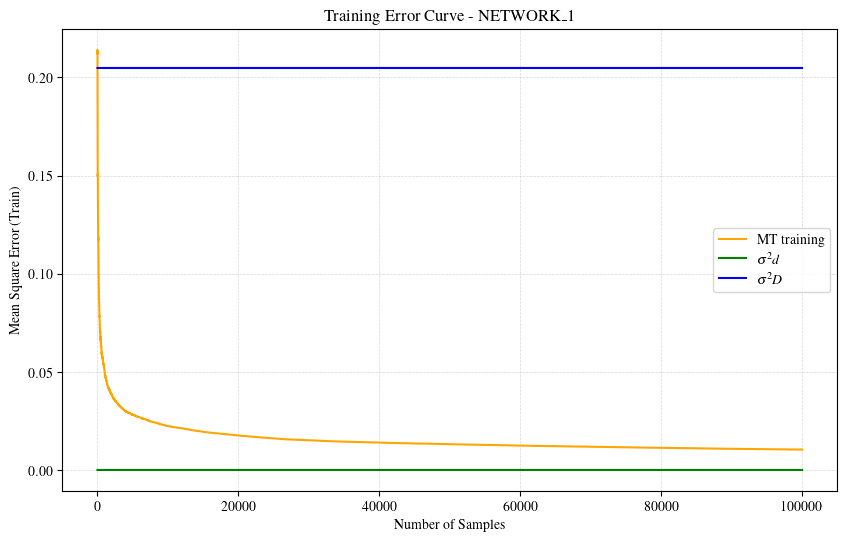

In [ ]:
#plot training curve for one MT network

network_idx = 0
save_path = f'/data/shiyu/projects/MT/MT_ICML_OOP/GW/GW_results/network{network_idx}_training_error_curve.pdf'

if network_idx >= len(networks_wrapper_GW.network_results):
    raise ValueError(f"Network index {network_idx} out of range")


results = networks_wrapper_GW.network_results[network_idx]

sigma_sq_d = [sigma ** 2 * d] * len(results.mean_MT_error)
sigma_sq_D = [sigma ** 2 * D] * len(results.mean_MT_error)



plt.figure(figsize=(10, 6))
plt.plot(results.mean_MT_error, color='orange', label='MT training')
plt.plot(sigma_sq_d, color='green', label=r'$\sigma^2 d$')
plt.plot(sigma_sq_D, color='blue', label=r'$\sigma^2 D$')
plt.legend()
plt.xlabel('Number of Samples')
plt.ylabel('Mean Square Error (Train)')
plt.title(f'Training Error Curve - {networks_wrapper_GW.network_names[network_idx]}')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)



if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches='tight')

plt.show()

# test

In [12]:
networks_wrapper_GW.analyze_networks()


Analyzing performance on 20000 test samples...
Analyzing NETWORK_1...
  Exhaustive Search: Error=0.010539, Complexity=2029568.0
  Mixed Order (MT): Error=0.013327, Complexity=52587.2
  First Order Only: Error=0.327292, Complexity=19912.0
  Zero Order Only: Error=0.011403, Complexity=479703.3

Analyzing NETWORK_2...
  Exhaustive Search: Error=0.021844, Complexity=415744.0
  Mixed Order (MT): Error=0.025166, Complexity=58952.6
  First Order Only: Error=1.264702, Complexity=13205.9
  Zero Order Only: Error=0.025612, Complexity=53962.0

Analyzing NETWORK_3...
  Exhaustive Search: Error=0.011033, Complexity=3622912.0
  Mixed Order (MT): Error=0.012768, Complexity=48659.1
  First Order Only: Error=0.363807, Complexity=20577.5
  Zero Order Only: Error=0.012952, Complexity=768715.5

Analyzing NETWORK_4...
  Exhaustive Search: Error=0.042306, Complexity=100352.0
  Mixed Order (MT): Error=0.042644, Complexity=44709.6
  First Order Only: Error=1.054214, Complexity=8194.0
  Zero Order Only: Error

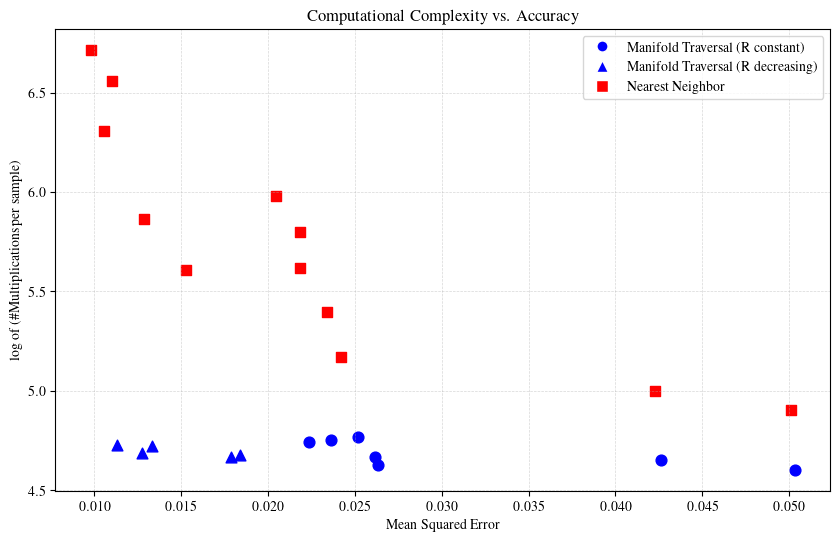

In [13]:
#plot trade-off figure
save_path = f'/data/shiyu/projects/MT/MT_ICML_OOP/GW/GW_results/MT_NN_GW_tradeoff.pdf'

configs = networks_wrapper_GW.get_hyperparameter_configs()
mt_accuracies = [r['mixed_order']['avg_distance'] for r in networks_wrapper_GW.analysis_results]
mt_complexities = [r['mixed_order']['avg_mults'] for r in networks_wrapper_GW.analysis_results]
nn_accuracies = [r['exhaustive']['avg_distance'] for r in networks_wrapper_GW.analysis_results]
nn_complexities = [r['exhaustive']['avg_mults'] for r in networks_wrapper_GW.analysis_results]

plt.figure(figsize=(10, 6))

for i in range(len(networks_wrapper_GW.networks)):
    marker_mt = 'o' if configs[i]['R_is_const'] else '^'
    plt.scatter(mt_accuracies[i], np.log10(mt_complexities[i]),
                marker=marker_mt, color='blue', s=60)
    plt.scatter(nn_accuracies[i], np.log10(nn_complexities[i]),
                marker='s', color='red', s=60)

plt.title('Computational Complexity vs. Accuracy')
plt.ylabel("log of (\#Multiplications per sample)")
plt.xlabel("Mean Squared Error")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Manifold Traversal (R constant)',
            markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='^', color='w', label='Manifold Traversal (R decreasing)',
            markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='s', color='w', label='Nearest Neighbor',
            markerfacecolor='red', markersize=8),
]
plt.legend(handles=legend_elements)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches='tight')

plt.show()

# Ablation Study

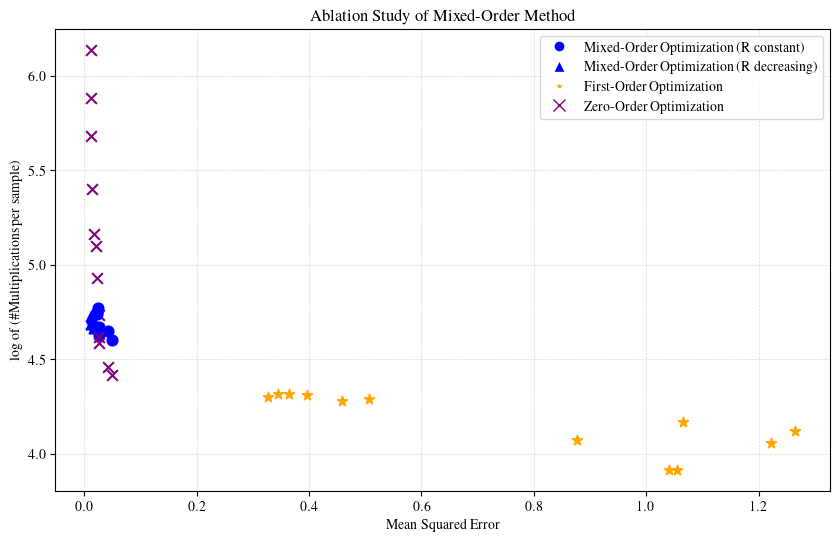

In [ ]:

save_path = f'/data/shiyu/projects/MT/MT_ICML_OOP/GW/GW_results/ablation_study_GW.pdf'

configs = networks_wrapper_GW.get_hyperparameter_configs()
mt_accuracies = [r['mixed_order']['avg_distance'] for r in networks_wrapper_GW.analysis_results]
mt_complexities = [r['mixed_order']['avg_mults'] for r in networks_wrapper_GW.analysis_results]
fom_accuracies = [r['first_order_only']['avg_distance'] for r in networks_wrapper_GW.analysis_results]
fom_complexities = [r['first_order_only']['avg_mults'] for r in networks_wrapper_GW.analysis_results]
zom_accuracies = [r['zero_order_only']['avg_distance'] for r in networks_wrapper_GW.analysis_results]
zom_complexities = [r['zero_order_only']['avg_mults'] for r in networks_wrapper_GW.analysis_results]


plt.figure(figsize=(10, 6))

for i in range(len(networks_wrapper_GW.networks)):
    marker_mt = 'o' if configs[i]['R_is_const'] else '^'
    plt.scatter(mt_accuracies[i], np.log10(mt_complexities[i]),
                marker=marker_mt, color='blue', s=60)
    plt.scatter(fom_accuracies[i], np.log10(fom_complexities[i]),
                marker='*', color='orange', s=60)
    plt.scatter(zom_accuracies[i], np.log10(zom_complexities[i]),
                marker='x', color='purple', s=60)

plt.title('Ablation Study of Mixed-Order Method')
plt.ylabel("log of (\#Multiplications per sample)")
plt.xlabel("Mean Squared Error")

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
            label='Mixed-Order Optimization (R constant)',
            markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='^', color='w',
            label='Mixed-Order Optimization (R decreasing)',
            markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='*', color='w',
            label='First-Order Optimization',
            markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='x', color='w',
            label='Zero-Order Optimization',
            markeredgecolor='purple', markersize=8, linestyle='None'),
]
plt.legend(handles=legend_elements)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)


if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches='tight')

plt.show()


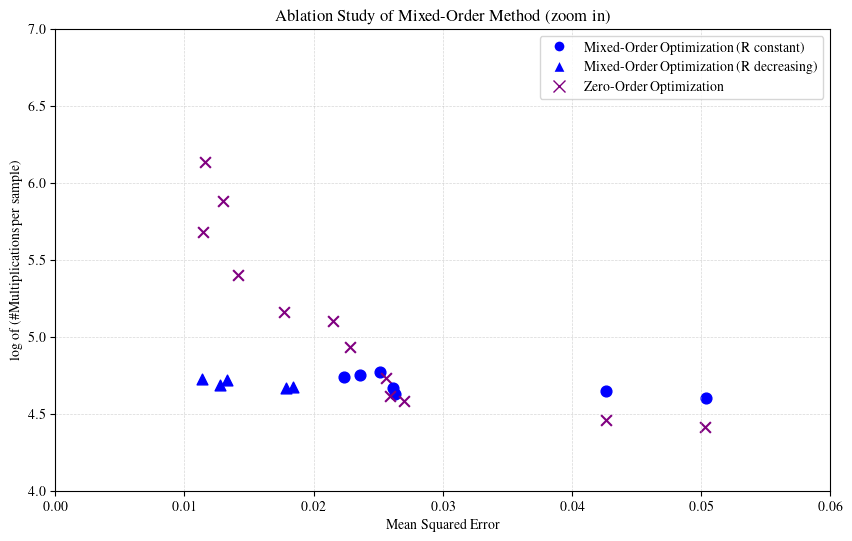

In [ ]:

save_path = f'/data/shiyu/projects/MT/MT_ICML_OOP/GW/GW_results/ablation_study_zoomin_GW.pdf'


configs = networks_wrapper_GW.get_hyperparameter_configs()
mt_accuracies = [r['mixed_order']['avg_distance'] for r in networks_wrapper_GW.analysis_results]
mt_complexities = [r['mixed_order']['avg_mults'] for r in networks_wrapper_GW.analysis_results]
zom_accuracies = [r['zero_order_only']['avg_distance'] for r in networks_wrapper_GW.analysis_results]
zom_complexities = [r['zero_order_only']['avg_mults'] for r in networks_wrapper_GW.analysis_results]

plt.figure(figsize=(10, 6))

for i in range(len(networks_wrapper_GW.networks)):
    marker_mt = 'o' if configs[i]['R_is_const'] else '^'
    plt.scatter(mt_accuracies[i], np.log10(mt_complexities[i]),
                marker=marker_mt, color='blue', s=60)
    plt.scatter(zom_accuracies[i], np.log10(zom_complexities[i]),
                marker='x', color='purple', s=60)

plt.title('Ablation Study of Mixed-Order Method (zoom in)')
plt.ylabel("log of (\#Multiplications per sample)")
plt.xlabel("Mean Squared Error")

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
            label='Mixed-Order Optimization (R constant)',
            markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='^', color='w',
            label='Mixed-Order Optimization (R decreasing)',
            markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='x', color='w',
            label='Zero-Order Optimization',
            markeredgecolor='purple', markersize=8, linestyle=None),
]
plt.legend(handles=legend_elements)

x_range=(0, 0.06)
y_range=(4, 7)
plt.xlim(x_range)
plt.ylim(y_range)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

if save_path:
    plt.savefig(save_path, format='pdf', bbox_inches='tight')

plt.show()